# VCC Laser Input Example

## Initial imports/function definitions

In [160]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('petrstyle.txt')
from matplotlib.ticker import NullFormatter
import glob, h5py
import scipy.io
import pandas as pd
import pydicom as dicom

from astra import Astra#, template_dir
from astra.plot import plot_fieldmaps, plot_stats, plot_stats_with_layout
import distgen
from distgen import Generator
from distgen.writers import *
from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.plot import marginal_plot

#Loads all example laser images into list
vcc = glob.glob('data/laser_mat_images/*.mat')

#slice plots
# from h5py import File
# from pmd_beamphysics.interfaces import opal
# from pmd_beamphysics.plot import slice_plot
# from pmd_beamphysics.plot import marginal_plot, density_plot

In [161]:
def parse_opal_emitted_dist(filename, names=['x', 'px','y','py','t','pz']):
    '''Read in particle distribution used 
    in OPAL-T simulation. Used to describe the 
    beam distribution as it leaves the cathode.'''
    dist = {}
    data = np.loadtxt(filename, skiprows=1)
    for i,name in enumerate(names):
        dist[name] = data[:,i]
    return dist
def parse_astra_dist(filename, header=['x', 'y', 'z', 'px','py', 'pz', 't', 'Q', 'ptype', 'flag']):
    '''
    Read in initial particle distribution used 
    in ASTRA simulation. Used to describe the 
    beam distribution as it leaves the cathode.
   
    t     = time in ns
    Q     = macro charge
    ptype = particle type (electron: 1)
    flag  = particle location (cathode: -1)
    '''
    #print(filename)
    data = pd.read_csv(filename, delim_whitespace=True, names=header)
    #print(data)
    #only return non traj probe particles at cathodeprint(astradist['z'])
    dist = data[data.flag == -1]
    return dist #dist

In [162]:
def make_tri(n, xmin, xmax, x):

    half = int(n/2)
    yr  = np.zeros(half*2)
    #step 1
    nr = int(n)
    xr = np.random.rand(nr)

    for j in range(0,nr):
        #step 3
        if j < half:
            yr[j] = (1- np.sqrt(1-xr[j]))*(xmax-xmin)  
        elif j >= half:
        #step 4 
            yr[j] = (-1 + np.sqrt(1-xr[j]))*(xmax-xmin) 

    #showplot(xr, yr)
    for k in range(0,len(x)):
        #print(y[k])
        if (-yr[k]/8 <= x[k] <= yr[k]/8):
            pass
            #x[k]=0
        else:
            #print(x[k])
            x[k]=0
            #pass

    #showplot(xr,x)
    return x, xr

In [163]:
# From Chris: https://github.com/slaclab/lcls-lattice/tree/master/distgen/models/cu_inj/vcc_image
def write_distgen_xy_dist(filename, image, resolution, resolution_units='m'):
    """
    Writes image data in distgen's xy_dist format
    
    Returns the absolute path to the file written
    
    """
    
    # Get width of each dimension
    widths = resolution * np.array(image.shape)
    
    # Form header
    header = f"""x {widths[1]} {widths[1]/2} [{resolution_units}]
y {widths[0]} {widths[0]/2}  [{resolution_units}]"""
    
    # Save with the correct orientation
    np.savetxt(filename, np.flip(image, axis=0), header=header, comments='')
    
    return os.path.abspath(filename)

### Setting the path of the ASTRA_BIN

In [164]:
#Possible generalization for environment dependency path
os.environ['ASTRA_BIN'] = os.getenv('ASTRA_BIN')
#print(os.getenv('ASTRA_BIN'))

In [165]:
#Edit this line to match your path if the above cell doesn't work
#%env ASTRA_BIN=/Users/colinrecker/Desktop/SLACForks/Astra

## Loading Laser Image and Generating Electron Distribution

### Initializing the laser image

In [166]:
#Picks first laser image
mat = scipy.io.loadmat(vcc[0])

#Scraping Name of File
laser_name = str(mat['data'][0][0][0][0])

#Image Reshaping
arr = mat['data']
dim = arr.shape[0]
#print(dim)
xy = int(np.sqrt(dim))
nrow = xy
ncol = xy
IMAGE = arr.reshape(nrow, ncol)[0][0][1]


### Plotting Laser Image

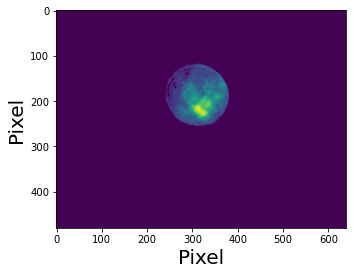

In [167]:
plt.imshow(IMAGE)#, extent=[0,1,0,1])
plt.ylabel('Pixel', size=20)
plt.xlabel('Pixel', size=20)
plt.savefig(f'plots/laser_images/{laser_name}.jpg', dpi=300, bbox_inches='tight')

### Generating associated .txt file for distgen

In [168]:
FOUT = write_distgen_xy_dist(f"astra-inputs/{laser_name}.txt", IMAGE, xy, resolution_units='um')

### Generating electron distribution with tumor image

In [169]:
#Specify tumor image input
image_input = 'data/dcmImages/field1.dcm'
image_name = 'field1'

In [170]:
#Centering image
def dcm_Crop(im_input):
    ds = dicom.dcmread(im_input)
    pixArr = ds.pixel_array
    dim = pixArr.shape
    height, width = dim[0], dim[1]
    maxIndex = np.where(pixArr == pixArr.max())
    maxHeightIndex = maxIndex[0]
    maxWidthIndex = maxIndex[1]
    distFromCent = abs(height/2 - maxHeightIndex) if maxHeightIndex > maxWidthIndex else abs(width/2 - maxWidthIndex)
    maxCropDist = height/2 - distFromCent if maxHeightIndex > maxWidthIndex else width/2 - distFromCent
    cropImg = pixArr[int(maxHeightIndex-maxCropDist):int(maxHeightIndex+maxCropDist), int(maxWidthIndex-maxCropDist):int(maxWidthIndex+maxCropDist)]
    padImg = np.pad(cropImg, [(124, 124), (124, 124)], mode='constant')
    #print(padImg)
    plt.imsave(f'data/cropImage/{image_name}.jpg', padImg)
    #plt.imshow(padImg)
    return f'data/cropImage/{image_name}.jpg'

In [171]:
#Distribution generation
dist_file = 'astra-inputs/distgen.yaml'
dist = Generator(dist_file, verbose=False)

dist.input['xy_dist']['file'] = dcm_Crop(image_input)
dist.input['n_particle'] = int(1e4)
dist.input['start']['MTE']['value'] = 130 

fwhm = 0.06/2.355 # 60 fs = 0.06 ps
dist.input['t_dist']['sigma_t']['value'] = fwhm
dist.input['total_charge']['value'] = 10

# dist.input['r_dist']['max_r']['value'] = 0.5

dist.run()
particles = dist.particles 
particles.write_astra('astra-inputs/astra_particles.txt')

### Plotting generated electrons

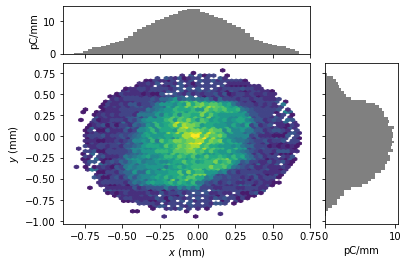

In [172]:
particles.plot('x','y')

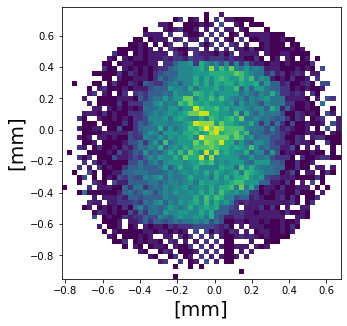

In [173]:
num_bins = 55
plt.figure(figsize=(5, 5))
astradist = parse_opal_emitted_dist('astra-inputs/astra_particles.txt', names=['x', 'y', 'z', 'px','py', 'pz', 't', 'Q', 'ptype', 'flag'])
xy = plt.hist2d(astradist['x']*10**3, astradist['y']*10**3, num_bins, facecolor='blue', cmin=2)#, alpha=0.5)
plt.ylabel('[mm]', size=20)
plt.xlabel('[mm]', size=20)
plt.savefig(f'plots/init_electron_dist/{image_name}.jpg', dpi=300)

# Run ASTRA

## Initializing simulation with xta.in file

In [174]:
astra_file = 'data/xta.in'
xta = Astra(initial_particles=particles, input_file=astra_file, verbose=False)

In [175]:
#Changing inputs on xta
xta.input['solenoid']['maxb(1)'] = 0.45
#xta.input['solenoid']

In [176]:
#xta.input['charge']

In [177]:
xta.input['newrun']['zstart'] = 0.0
xta.input['newrun']['zstop'] = 0.25
xta.input['charge']['lspch'] = False
xta.input['newrun']['zphase'] = 50

## Running Astra simulation

In [178]:
xta.run()

In [179]:
# xta.input_file

In [180]:
#xta.archive('xta_60fs_1mm_10pC_noSC_laser_weak_solenoid_0.45_zstop_5.5.h5')

In [181]:
#xta.load_archive('archives/xta_60fs_1mm_10pC_SC_laser_weak_solenoid_0.45_zstop_5.5.h5')

### Plotting final energy distribution

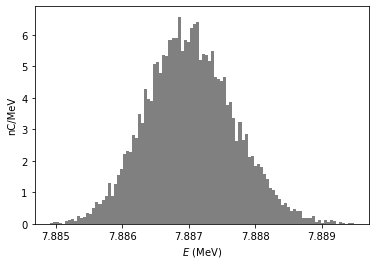

In [182]:
test = xta.particles[-1].plot('energy')
plt.savefig(f'plots/energy_dist/{image_name}.jpg', dpi=250)

### Plotting final electron distributions

0.24999546410545995


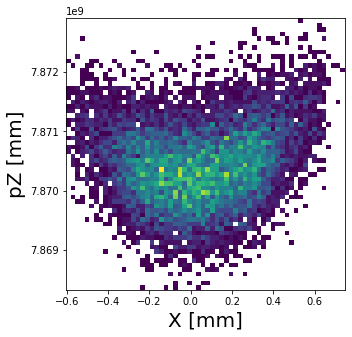

In [183]:
#xta.load_archive('archives/xta_60fs_1mm_1pC_SC_laser_test.h5')
plt.figure(figsize=(5, 5))
# xta.particles[-1].plot('x','y')
xtapart = xta.particles[-1]
num_bins = 60
xy = plt.hist2d(xtapart.x*10**3, xtapart.pz*10**3, num_bins, facecolor='blue', cmin=1)#, alpha=0.5)
print(np.mean(xtapart.z))
plt.ylabel('pZ [mm]', size=20)
plt.xlabel('X [mm]', size=20)
plt.savefig(f'plots/final_electron_dist/{image_name}.jpg', dpi=300, bbox_inches='tight')

### Comparison between initial and final electron distributions

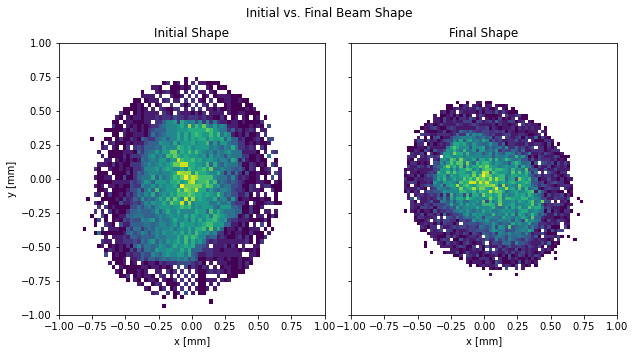

In [184]:
#Super plot
fig, plots = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1)

#Initial Plot
num_bins = 55
initialxy = plt.subplot(1,2,1)
plt.hist2d(astradist['x']*10**3, astradist['y']*10**3, num_bins, facecolor='blue', cmin=2)
plots[0].set(title='Initial Shape', xlabel='x [mm]', ylabel='y [mm]')

#Final plot
finalxy = plt.subplot(1,2,2)
xtapart = xta.particles[-1]
num_bins = 55
plt.hist2d(xtapart.x*10**3, xtapart.y*10**3, num_bins, facecolor='blue', cmin=1)
plots[1].set(title='Final Shape', xlabel='x [mm]', xlim=[-1, 1], ylim=[-1, 1])


plt.suptitle("Initial vs. Final Beam Shape")
#plt.tight_layout

plt.savefig(f'plots/compare_dist/{image_name}.jpg', dpi=300, bbox_inches='tight')

In [185]:
#len(xta.particles)

### Plotting beam size along z-axis

TypeError: 'list' object is not callable

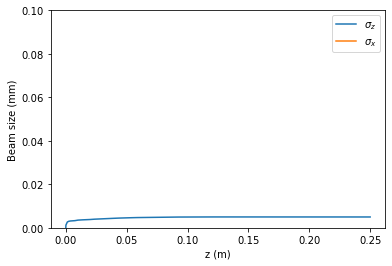

In [186]:
plt.plot(xta.stat('mean_z'), xta.stat('sigma_z')*10**3, '-', label="$\sigma_z$")
plt.plot(xta.stat('mean_z'), xta.stat('sigma_x')*10**3, '-', label="$\sigma_x$")
plt.xlabel('z (m)')
plt.ylabel('Beam size (mm)')
plt.legend(loc='upper right')
plt.ylim(0,0.1)
plt.xlim(0,1)
plt.grid()

### Plotting beam energy along z-axis

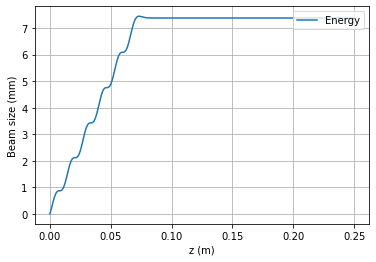

In [ ]:
plt.plot(xta.stat('mean_z'), xta.stat('mean_kinetic_energy')*10**-6, '-', label="Energy")
# plt.plot(xta.stat('mean_z'), xta.stat('sigma_x')*10**3, '-', label="$\sigma_x$")
plt.xlabel('z (m)')
plt.ylabel('Beam size (mm)')
plt.legend(loc='upper right')
# plt.ylim(0,0.6)
# plt.xlim(0,0.7)
plt.grid()

# Movie